##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [2]:
pip install torch torchvision

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/16/dd/1bf10180ba812afa1aa7427466083d731bc37b9a1157ec929d0cfeef87eb/torch-2.1.0-cp311-none-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/23/84/46481327771d4f63feb59dd0d9e1cd6a42e985dbd371965f486a5bf9f323/torchvision-0.16.0-cp311-cp311-macosx_10_13_x86_64.whl.metadata
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/ea/c8/407364710cb9631ce306a97abff2d61836d603b258b5e5399b5f12a7f787/filelock-3.13.0-py3-none-any.whl.metadata
  Obtaining dependency information for typing-extensions from https://files.pythonhosted.org/packages/24/21/7d397a4b7934ff4028987914ac1044d3b7d52712f30e2ac7a2ae5bc86dd0/typing_extensions-4.8.0-py3-none-any.whl.metadata
  Using cached typing_extensions-4.8.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Obtaining de

In [113]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [114]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [115]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [116]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [117]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [118]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [119]:
df.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


In [120]:
# X : Latitude coordinate of the crime incident.
# Y : Longitude Coordinate of the crime incident.
# Area_Command: The police designation of the bureau of operation.
# NIBRSOffenseCode: Classification code for the crime committed.
# DayOfWeek: The day of the week when the crime was reported.
# Time: The hour of the day when the crime was reported.
# VictimCount: The number of persons involved in the crime incident.

**Input Variables:**
    
    X (Longitude)
    
    Y (Latitude)
    
    ReportedOn (Hour of the day and Day of the week can be extracted from here)
    
    Area_Command
    
    NIBRSOffenseCode
    
**Target Variable:**

    VictimCount

In [121]:
ranges = df.agg(["min", "max"])
ranges.T  

,min,max
X,-116.000000,-114.62557
Y,35.068419,37.00000
Area_Command,0.000000,11.00000
NIBRSOffenseCode,0.000000,2.00000
DayOfWeek,0.000000,6.00000
Time,0.000000,23.00000
VictimCount,0.000000,6.00000


## Data Scaling, Shifting, or Normalization:

**Longitude (X) & Latitude (Y):** 
    These are already in a relatively normalized range, These does not need normalization for most models. However, for neural networks, normalization for this columns could be an added Advantage.

**ReportedOn:** We need to extract the hour of the day and the day of the week from this input column. Once extracted, hour might benefit from normalization, and day of the week can be one-hot encoded.
    
**VictimCount (Target Variable):** Depending on the model especially if neural networks, this might help from normalization.
    
**Area_Command & NIBRSOffenseCode:** These are categorical and would benefit from one-hot encoding.
    
**Other columns:** Depending on model used and further feature engineering, additional scaling/normalization might be necessary particularly if neural networks models are being used like every other column above.

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [122]:
from torch.utils.data import DataLoader, random_split, Subset
feature_columns = ['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']

Features = df[feature_columns]
target = df['VictimCount']


# Split the data into training and testing
dataset = TensorDataset(torch.Tensor(Features.values), torch.Tensor(target.values))

training_data_Size = int(0.75 * len(dataset))  # 75% for training
testing_data_Size = len(dataset) - training_data_Size  # 25% for testing

# Randomly split dataset into training and testing datasets
Data_Trained, Data_Tested = random_split(dataset, [training_data_Size, testing_data_Size])

# Double-check the length of the training dataset
print(len(Data_Trained))

# Define a batch size
batch_size = 64  

# Create DataLoader objects for training and testing datasets
trained_data_loader = DataLoader(Data_Trained, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Data_Tested, batch_size=batch_size, shuffle=False)

# Verify the shape of the data
for batch in trained_data_loader:
    feature_inputs, data_target = batch
    print("Input shape:", feature_inputs.shape)
    print("Target shape:", data_target.shape)
    break

206
Input shape: torch.Size([64, 6])
Target shape: torch.Size([64])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper computed_loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

#### 1. Proper Loss Function:
For a regression problem where we aim to predict a continuous value, the Mean Squared Error (MSE) is an appropriate computed_loss function. This is consistent with use of nn.MSELoss() while we code.

#### 2. Size of Predicted Output:
The size of the predicted output should be a single continuous value representing the number of crime victims.

#### 3. Choice of Architecture:
The neural network model in the code consists of four hidden layers. 
For activation functions, the first hidden layer uses ReLU, and the subsequent layers employ the tanh activation function. 
This structure is aimed at capturing potential nonlinear relationships in the dataset and enhancing the model predictive capabilities.

#### 4. Optimizer and Learning Rate:
We'll use, the Adadelta optimizer for updating the model's weights. 
Adadelta is an adaptive learning rate optimizer and has been shown to perform well in multiple scenarios. 
The learning rate is set to 0.001, which can be adjusted based on model performance.

#### 5. Training Loop and Epochs:
We will use a loop to iterate over epochs.
A inner loop to iterate over batches of data.

#### 6. Model Evaluation:
At the end of each epoch, we will calculate the MSE(computed_loss function) on test data to evaluate our model.



In [123]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

batch_size = 48
Data_Trained = TensorDataset(torch.Tensor(X_train.values), torch.Tensor(y_train.values))
Data_Tested = TensorDataset(torch.Tensor(X_test.values), torch.Tensor(y_test.values))
trained_data_loader = DataLoader(Data_Trained, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Data_Tested, batch_size=batch_size, shuffle=False)

# Define a simple regression model
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        
        # Define hidden layer dimensions
        hidden_dim1 = 128
        hidden_dim2 = 64
        hidden_dim3 = 32
        # Define dropout rate
        dropout_rate = 0.2
        # Fully connected layers
        self.fc1 = nn.Linear(input_size, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, 1)  # Final layer has 1 neuron for regression output
        
        # Activation and Dropout
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# Define the model, computed_loss function, and optimizer
input_size = 6  # Number of input features
hidden_size = 64  # Number of neurons in the hidden layer
output_size = 1  # Regression, single output
model = RegressionModel(input_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adadelta (model.parameters(), lr=0.001)


# Training loop
epoch_count = 500

for epoch in range(epoch_count):
    model.train()
    for batch in trained_data_loader:
        feature_inputs, data_target = batch
        predictions = model(feature_inputs)  
        target = data_target  
        target = target.view(-1)
        criterion = nn.MSELoss()
        computed_loss = criterion(predictions.flatten(), target.flatten())
        optimizer.zero_grad()
        computed_loss.backward()
        optimizer.step()

    # Calculate MSE on test data
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch in test_loader:
            feature_inputs, data_target = batch
            outputs = model(feature_inputs)
            test_loss += criterion(outputs.flatten(), data_target.flatten())

    print(f'Epoch [{epoch + 1}/{epoch_count}], Test Loss: {test_loss.item():.4f}')


Epoch [1/500], Test Loss: 12.9215
Epoch [2/500], Test Loss: 12.6470
Epoch [3/500], Test Loss: 12.3698
Epoch [4/500], Test Loss: 12.0879
Epoch [5/500], Test Loss: 11.7920
Epoch [6/500], Test Loss: 11.5297
Epoch [7/500], Test Loss: 11.2492
Epoch [8/500], Test Loss: 10.9410
Epoch [9/500], Test Loss: 10.6464
Epoch [10/500], Test Loss: 10.3495
Epoch [11/500], Test Loss: 10.0688
Epoch [12/500], Test Loss: 9.8024
Epoch [13/500], Test Loss: 9.5385
Epoch [14/500], Test Loss: 9.2582
Epoch [15/500], Test Loss: 8.9769
Epoch [16/500], Test Loss: 8.7150
Epoch [17/500], Test Loss: 8.4788
Epoch [18/500], Test Loss: 8.2426
Epoch [19/500], Test Loss: 7.9805
Epoch [20/500], Test Loss: 7.7439
Epoch [21/500], Test Loss: 7.5148
Epoch [22/500], Test Loss: 7.3119
Epoch [23/500], Test Loss: 7.0967
Epoch [24/500], Test Loss: 6.8759
Epoch [25/500], Test Loss: 6.6911
Epoch [26/500], Test Loss: 6.4987
Epoch [27/500], Test Loss: 6.3032
Epoch [28/500], Test Loss: 6.1048
Epoch [29/500], Test Loss: 5.8881
Epoch [30/50

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the computed_loss function different?
* Calculate the Accuracy for test data as the number of corrected_data classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [124]:
num_classes = df['VictimCount'].nunique()
print(num_classes)

7


#### 2. Changes in the Model Architecture for Classification:
The output layer will have as many neurons as there are classes.
Typically, a softmax activation function is used in the output layer for multi-class classification.

#### 3. Changes in the Loss Function for Classification:
For classification problems, Cross-Entropy Loss is commonly used. In PyTorch, you can use nn.CrossEntropyLoss(). Note that this computed_loss function in PyTorch combines both a softmax activation and the actual cross-entropy computed_loss calculation, so you don't need a separate softmax layer in your model.

In [125]:
import torch.nn as nn

class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


batch_size = 48
Data_Trained = TensorDataset(torch.Tensor(X_train.values), torch.LongTensor(y_train.values))
Data_Tested = TensorDataset(torch.Tensor(X_test.values), torch.LongTensor(y_test.values))
trained_data_loader = DataLoader(Data_Trained, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Data_Tested, batch_size=batch_size, shuffle=False)

# Define the model, computed_loss function, and optimizer for classification
output_size = len(df['VictimCount'].unique())  # Number of unique classes
model = ClassificationModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [127]:
def train_one_epoch(model, trained_data_loader, optimizer, criterion):
    model.train()  # Set the model to training mode
    total_loss_function_value = 0.0
    
    for feature_inputs, data_target in trained_data_loader:
        # Forward pass
        outputs = model(feature_inputs)
        # Compute computed_loss
        computed_loss = criterion(outputs, data_target)
        # Zero the gradients
        optimizer.zero_grad()
        # Backward pass and optimization
        computed_loss.backward()
        optimizer.step()
        total_loss_function_value += computed_loss.item()
        
    loss_function_average = total_loss_function_value / len(trained_data_loader)
    return loss_function_average

def evaluate_model(model, test_loader, criterion):
    model.eval()  
    corrected_data = 0
    total = 0
    total_loss_function_value = 0.0
    
    with torch.no_grad():
        for feature_inputs, data_target in test_loader:
            outputs = model(feature_inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += data_target.size(0)
            corrected_data += (predicted == data_target).sum().item()
            computed_loss = criterion(outputs, data_target)
            total_loss_function_value += computed_loss.item()
    loss_function_average = total_loss_function_value / len(test_loader)
    accuracy = 100 * corrected_data / total
    return loss_function_average, accuracy

epoch_count = 500
for epoch in range(epoch_count):
    train_loss = train_one_epoch(model, trained_data_loader, optimizer, criterion)
    test_loss, accuracy = evaluate_model(model, test_loader, criterion)
    print(f'Epoch [{epoch + 1}/{epoch_count}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Epoch [1/500], Train Loss: 1.0190, Test Loss: 1.0730, Test Accuracy: 60.87%
Epoch [2/500], Train Loss: 1.0626, Test Loss: 1.1992, Test Accuracy: 42.03%
Epoch [3/500], Train Loss: 0.9972, Test Loss: 1.1008, Test Accuracy: 60.87%
Epoch [4/500], Train Loss: 1.0289, Test Loss: 1.1212, Test Accuracy: 62.32%
Epoch [5/500], Train Loss: 0.9809, Test Loss: 1.2299, Test Accuracy: 43.48%
Epoch [6/500], Train Loss: 1.0039, Test Loss: 1.0855, Test Accuracy: 62.32%
Epoch [7/500], Train Loss: 1.0049, Test Loss: 1.1808, Test Accuracy: 42.03%
Epoch [8/500], Train Loss: 0.9858, Test Loss: 1.1030, Test Accuracy: 62.32%
Epoch [9/500], Train Loss: 0.9771, Test Loss: 1.1889, Test Accuracy: 40.58%
Epoch [10/500], Train Loss: 0.9880, Test Loss: 1.0625, Test Accuracy: 59.42%
Epoch [11/500], Train Loss: 0.9763, Test Loss: 1.2102, Test Accuracy: 42.03%
Epoch [12/500], Train Loss: 1.0110, Test Loss: 1.1219, Test Accuracy: 62.32%
Epoch [13/500], Train Loss: 0.9896, Test Loss: 1.2062, Test Accuracy: 40.58%
Epoch [1

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the corrected_data class label.

### **Experience with Tasks 3 and 4:**

In tasks 3 and 4,  We did regression and classification on data using neural networks to solve two different problems: 
a. predicting the number of crime victims as a continuous value 
b. classifying the number of victims into distinct categories.

**Task 3 (Regression):**
- The model architecture involved a deeper network with three hidden layers, using LeakyReLU activations and dropout for some regularization.
- Used computed_loss function was the Mean Squared Error (MSE), which is standard for regression tasks.
- The Adadelta optimizer was used with a learning rate of 0.001.
- After training, the model's performance was evaluated using the MSE on the test set.

**Task 4 (Classification):**
- The architecture is simpler with just one hidden layer and ReLU activation.
- Given the classification type of problem, Cross-Entropy computed_loss is chosen.
- The Adam optimizer, which is quite popular and effective in practice, is used for training.
- The model's performance was examined by calculating the accuracy on the test set, which provides a more intuitive metric for classification tasks.

**Comparison:**
- In terms of complexity, Task 3 model was more intricate due to the depth of the network and additional regularization techniques. This could be an attempt to capture more complex patterns in predicting a continuous value.
- Task 4 model was more straightforward but required additional preprocessing to handle categorical data_target. The accuracy metric used for evaluation also gives a clearer indication of how well the model performs in practical terms, as it translates directly to the percentage of corrected_data predictions.

**Which one worked better? Why?**
- The answer depends on te the given problem.
- If you need to predict crime victim counts as real numbers, Task 3 is more appropriate.
- If you want to categorize the counts into classes, Task 4 fits better.
- The results indicate that classification recieved higher accuracy, but evaluation metric should align with your task goals.


In conclusion, both tasks offered unique insights. The experience showed the importance of choosing the right architecture, computed_loss function, and evaluation metrics depending on the problem nature.

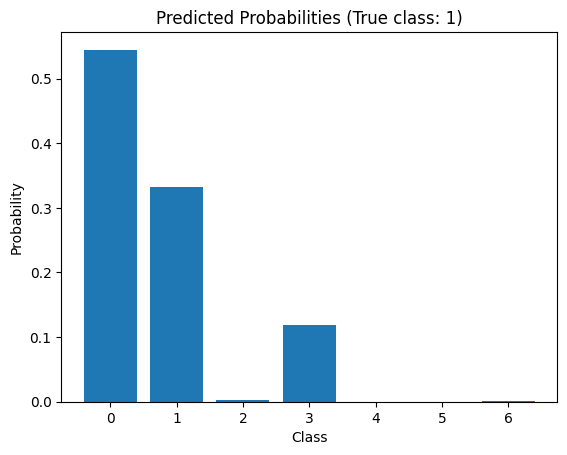

In [128]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def find_misclassified_example(model, test_loader):
    model.eval()
    with torch.no_grad():
        for feature_inputs, data_target in test_loader:
            outputs = model(feature_inputs)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(data_target)):
                if predicted[i] != data_target[i]:  # Misclassification found
                    return feature_inputs[i], outputs[i], data_target[i]
    return None, None, None

# Get a misclassified example
input_example, output_example, true_label = find_misclassified_example(model, test_loader)

if input_example is not None:
    # Calculate softmax probabilities
    probabilities = F.softmax(output_example, dim=0)
    probabilities = probabilities.cpu().numpy()

    # Plot the probabilities in a bar chart
    classes = list(range(output_size))  # Assuming output_size contains the number of classes
    plt.bar(classes, probabilities)
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title(f'Predicted Probabilities (True class: {true_label.item()})')
    plt.show()
else:
    print("Couldn't find a misclassified example!")


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


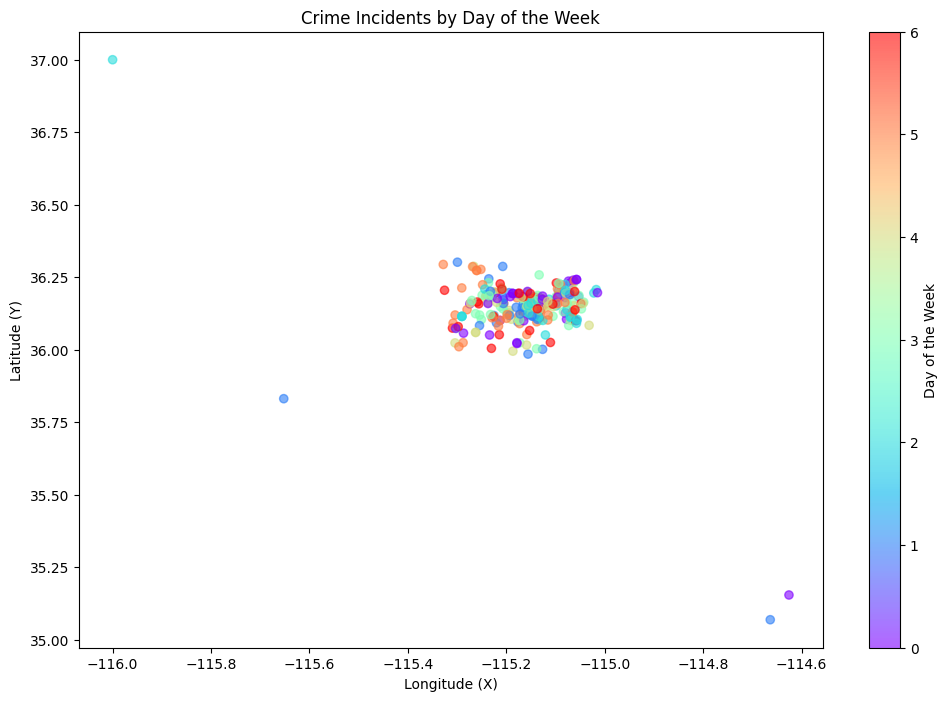

In [129]:
import matplotlib.pyplot as plt

# Task 6.1: Scatter plot with color representing day of the week
plt.figure(figsize=(12, 8))
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='rainbow', alpha=0.6)
plt.colorbar(label='Day of the Week')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Day of the Week')
plt.show()


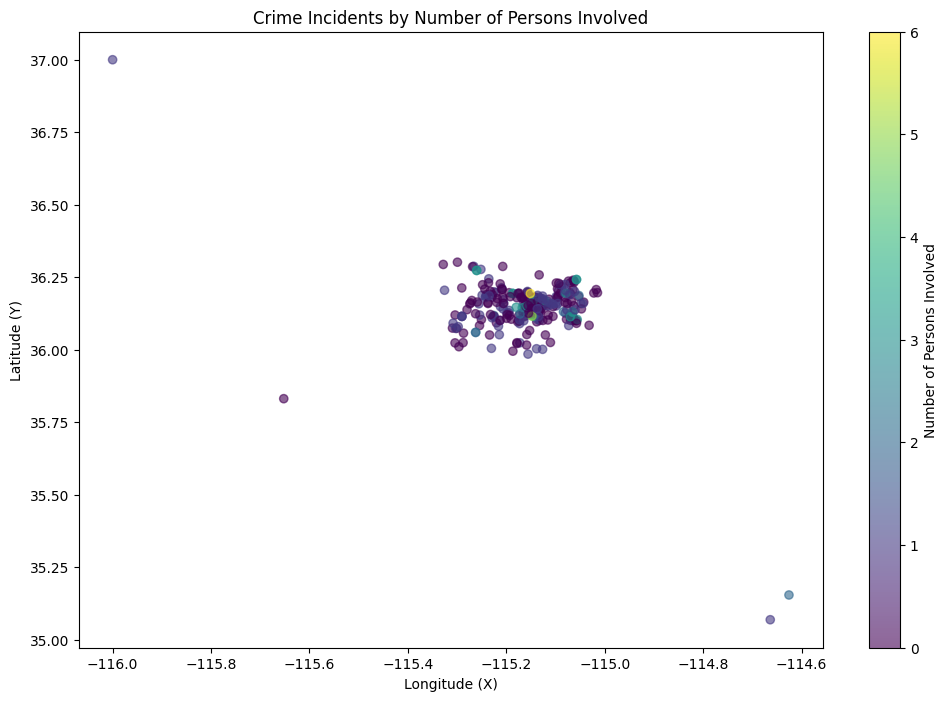

In [130]:
plt.figure(figsize=(12, 8))
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Number of Persons Involved')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Number of Persons Involved')
plt.show()

In [131]:
# Task 6.3: Counting and sorting crimes by day of the week
crime_counts_by_day = df['DayOfWeek'].value_counts().sort_index()
crime_counts_by_day


DayOfWeek
0    40
1    37
2    32
3    44
4    51
5    43
6    28
Name: count, dtype: int64